
Processando coluna: cap-shape
Taxa de acerto MICE: 3.19%
Taxa de acerto moda global: 49.11%

Processando coluna: cap-surface
Taxa de acerto MICE: 18.53%
Taxa de acerto moda global: 41.58%

Processando coluna: bruises
Taxa de acerto MICE: 96.90%
Taxa de acerto moda global: 57.62%

Processando coluna: odor
Taxa de acerto MICE: 63.74%
Taxa de acerto moda global: 50.18%

Processando coluna: gill-color
Taxa de acerto MICE: 12.06%
Taxa de acerto moda global: 24.11%


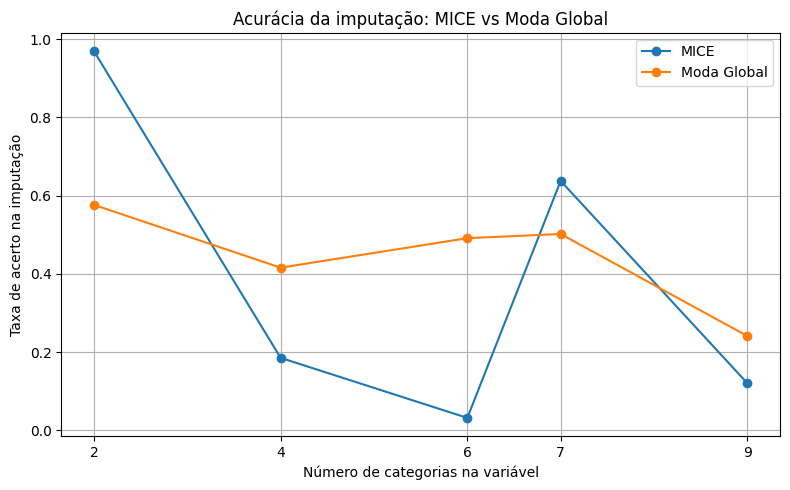

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer  # habilita IterativeImputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OrdinalEncoder

# 1. Carregar dados
file_path = 'mushrooms_data/agaricus-lepiota.data'
columns = [
    'class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
    'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
    'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
    'stalk-surface-below-ring', 'stalk-color-above-ring',
    'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
    'ring-type', 'spore-print-color', 'population', 'habitat'
]

df = pd.read_csv(file_path, header=None, names=columns)
df.replace('?', np.nan, inplace=True)
df_full = df.dropna().reset_index(drop=True)  # usar apenas linhas completas

# Colunas para testar
test_cols = ['cap-shape', 'cap-surface', 'bruises', 'odor', 'gill-color']

# Parâmetros
missing_rate = 0.2
np.random.seed(42)

# Resultados
num_categories = []
accuracy_mice = []
accuracy_mode = []

for col in test_cols:
    print(f"\nProcessando coluna: {col}")
    
    df_missing = df_full.copy()
    n_missing = int(len(df_missing) * missing_rate)
    missing_indices = np.random.choice(df_missing.index, size=n_missing, replace=False)
    df_missing.loc[missing_indices, col] = np.nan
    
    # Codificação ordinal de todas as colunas (necessário para IterativeImputer)
    encoder = OrdinalEncoder()
    df_encoded = df_missing.copy()
    df_encoded[df_encoded.columns] = encoder.fit_transform(df_encoded)
    
    # Aplicar MICE para imputar os missing na coluna atual (e outros missing se houver)
    mice_imputer = IterativeImputer(random_state=42, max_iter=10, sample_posterior=False)
    df_imputed_array = mice_imputer.fit_transform(df_encoded)
    
    # Reconstruir dataframe imputado
    df_imputed = pd.DataFrame(df_imputed_array, columns=df_encoded.columns)
    
    # Recuperar labels originais para a coluna imputada
    col_index = df_encoded.columns.get_loc(col)
    categories_col = encoder.categories_[col_index]
    
    # Como o resultado da imputação é float, arredondar para o inteiro mais próximo
    col_imputed_int = np.round(df_imputed[col]).astype(int)
    col_imputed_labels = categories_col[col_imputed_int]
    
    # DataFrame com coluna imputada via MICE
    df_imputed_mice = df_missing.copy()
    df_imputed_mice.loc[missing_indices, col] = col_imputed_labels[missing_indices]
    
    # Imputação por moda global
    df_imputed_mode = df_missing.copy()
    global_mode = df_full[col].mode().iloc[0]
    df_imputed_mode.loc[missing_indices, col] = global_mode
    
    # Avaliar acurácia
    true_values = df_full.loc[missing_indices, col]
    pred_mice = df_imputed_mice.loc[missing_indices, col]
    acc_mice = (true_values == pred_mice).mean()
    
    pred_mode = df_imputed_mode.loc[missing_indices, col]
    acc_mode = (true_values == pred_mode).mean()
    
    num_categories.append(df_full[col].nunique())
    accuracy_mice.append(acc_mice)
    accuracy_mode.append(acc_mode)
    
    print(f"Taxa de acerto MICE: {acc_mice:.2%}")
    print(f"Taxa de acerto moda global: {acc_mode:.2%}")

# Ordenar resultados
results = pd.DataFrame({
    'num_categories': num_categories,
    'accuracy_mice': accuracy_mice,
    'accuracy_mode': accuracy_mode
}).sort_values(by='num_categories')

# Plot
plt.figure(figsize=(8, 5))
plt.plot(results['num_categories'], results['accuracy_mice'], marker='o', label='MICE')
plt.plot(results['num_categories'], results['accuracy_mode'], marker='o', label='Moda Global')
plt.xticks(results['num_categories'])
plt.xlabel('Número de categorias na variável')
plt.ylabel('Taxa de acerto na imputação')
plt.title('Acurácia da imputação: MICE vs Moda Global')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
